# Patronizing and Condescending Language Detection

In [26]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from dont_patronize_me import DontPatronizeMe
import random
from wordcloud import WordCloud
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers import Trainer, TrainingArguments
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import os
from collections import Counter
from urllib import request
os.environ["WANDB_DISABLED"] = "true"

In [21]:
# check gpu
# check which gpu we're using
!nvidia-smi
cuda_available = torch.cuda.is_available()

if cuda_available:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print('Cuda available? ',cuda_available)

Sun Feb 20 00:27:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:25:00.0 Off |                  N/A |
| 40%   28C    P8    21W / 350W |     13MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# 1.1 Data analysis of the training data

In [5]:
dpm = DontPatronizeMe('.', 'task4_test.tsv')

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


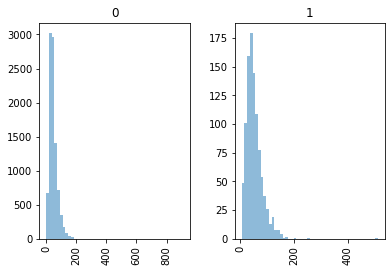

In [6]:
def count_words(sentence):
    return len(sentence.split())
dpm.load_task1()
dpm.load_task2(return_one_hot=True)
df = dpm.train_task1_df
df['lenght'] = df['text'].apply(count_words)
hist = df['lenght'].hist(by=df['label'], bins = 50, alpha = 0.5)
#hist = df['lenght'].hist(by=df['orig_label'], bins = 10, alpha = 0.5)
#hist = df['country'].hist(by=df['label'])
#hist = df['keyword'].hist(by=df['orig_label'])
plt.savefig('histo.jpg', dpi=500)

In [8]:
def generate_cloud(label,label_type,df):

    if label_type == "label ":
        text = df[df['label'] == label]['text'].values
    else:
        text = df[df['orig_label'] == label]['text'].values
    
    wordcloud = WordCloud().generate(str(text))
    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

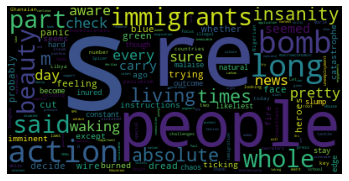

In [9]:
generate_cloud(0,"label ",dpm.train_task1_df)

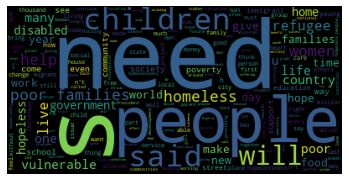

In [10]:
generate_cloud(1,"label ",dpm.train_task1_df)

# 1.2 Qualitative assessment of the dataset

In [11]:
# To be done

# 2 Modelling

## 2.1 Load training, validation and test set

In [12]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [13]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)
print("Original Training Length: ",len(trids))
print("Original Test Length: ",len(teids))

Original Training Length:  8375
Original Test Length:  2094


In [14]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

trdf1 = pd.DataFrame(rows)
from sklearn.model_selection import train_test_split
trdf1, valdf1 = train_test_split(trdf1, test_size=0.1)

In [15]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

tedf1 = pd.DataFrame(rows)

In [16]:
# downsample negative instances
# Training
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)
training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

# Validation
pcldf = valdf1[valdf1.label==1]
npos = len(pcldf)
validation_set1 = pd.concat([pcldf,valdf1[valdf1.label==0][:npos*2]])

# Testing
pcldf = tedf1[tedf1.label==1]
npos = len(pcldf)
test_set1 = pd.concat([pcldf,tedf1[tedf1.label==0][:npos*2]])

print("Training set length: ",len(training_set1))
print("Validation set length: ",len(validation_set1))
print("Testing set length: ",len(test_set1))

Training set length:  2142
Validation set length:  240
Testing set length:  597


In [17]:
class DpmDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        self.tokenizer = tokenizer
        self.texts = list(input_set['text'])
        self.labels = list(input_set['label'])
        
    def collate_fn(self, batch):

        texts = []
        labels = []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=256)
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        item = {'text': self.texts[idx],
                'label': self.labels[idx]}
        return item

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [19]:
train_dataset = DpmDataset(tokenizer, training_set1)

In [20]:
# Print some example in training set
batch = [sample for sample in train_dataset]

encodings = train_dataset.collate_fn(batch[:10])

for key, value in encodings.items():
  print(f"{key}: {value.numpy().tolist()}")

input_ids: [[101, 107, 107, 107, 1636, 18677, 117, 1242, 1104, 2292, 1132, 8940, 117, 1132, 7127, 1111, 170, 1618, 2174, 117, 107, 107, 18393, 1163, 119, 107, 107, 1284, 1444, 1106, 13346, 3403, 1105, 5431, 2500, 117, 1105, 1831, 1103, 13037, 1150, 19685, 1103, 1211, 8018, 1234, 119, 1284, 1444, 1106, 4134, 1103, 6176, 1104, 1103, 2463, 119, 107, 107, 107, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 107, 107, 107, 1430, 10637, 1103, 2454, 112, 188, 5044, 9965, 1104, 3935, 18986, 1116, 1987, 10779, 8827, 4867, 3822, 1112, 170, 1648, 2235, 1104, 8676, 1863, 119, 1130, 3558, 2657, 1920, 1106, 1343, 1107, 1444, 117, 1105, 2368, 1177, 2191, 8709, 1104, 1471, 117, 1119, 1110, 21964, 1639, 1105, 7495, 8676, 1863, 119, 146, 3254, 2354, 1181, 1987, 10779, 8827, 4867, 3822, 112, 188, 8268, 1106, 4607, 1103, 2491, 1104, 1343, 1750, 2

## 2.2 Construct Model

In [22]:
class pcl_detection(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)
        
        # Task A
        self.projection_a = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                                torch.nn.Linear(config.hidden_size, 2))
        
        # Task B
        # TBA
        
        # Task C
        # TBA
        
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
 
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Logits A
        logits_a = self.projection_a(outputs[1])
        
        return logits_a

In [27]:
# Define Loss function
class Trainer_pcl_detection(Trainer):
    def compute_loss(self, model, inputs):
        labels = {}
        labels['label'] = inputs.pop('label')

        outputs = model(**inputs)

        loss_task_a = nn.CrossEntropyLoss()
        labels = labels['label']
        loss = loss_task_a(outputs.view(-1, 2), labels.view(-1))
        
        return loss

## 2.3 Train

In [28]:
def main():
    
    #model = BERT_hate_speech.from_pretrained(model_name)\
    model = pcl_detection.from_pretrained("bert-base-cased")
    #call our custom BERT model and pass as parameter the name of an available pretrained model    
    training_args = TrainingArguments(
        output_dir='./experiment/hate_speech',
        learning_rate = 0.0001,
        logging_steps= 100,
        per_device_train_batch_size=32,
        num_train_epochs = 3,
    )
    trainer = Trainer_pcl_detection(
        model=model,                         
        args=training_args,                 
        train_dataset=train_dataset,                   
        data_collator=train_dataset.collate_fn
    )
    trainer.train()

    trainer.save_model('./models/pcl_bert_finetuned/')



In [29]:
main()

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/jason/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cach

Step,Training Loss
100,0.520200
200,0.315700




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/pcl_bert_finetuned/
Configuration saved in ./models/pcl_bert_finetuned/config.json
Model weights saved in ./models/pcl_bert_finetuned/pytorch_model.bin


## 2.4 Validation

In [40]:
def predict_pcl(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=256)
  encodings.to(device)
  output = model(**encodings)
  preds = torch.max(output, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

def evaluate(model, tokenizer, data_loader):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  with torch.no_grad():
    for data in tqdm(data_loader): 

      labels = {}
      labels['label'] = data['label']

      tweets = data['text']

      pred = predict_pcl(tweets, tokenizer, model)

      preds.append(np.array(pred['prediction'].cpu()))
      tot_labels.append(np.array(labels['label'].cpu()))

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  

  return preds, tot_labels

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#your saved model name here
model_name = './models/pcl_bert_finetuned/' 
model = pcl_detection.from_pretrained(model_name)
model.to(device)

###########################
# Validation set
###########################

val_dataset = DpmDataset(tokenizer, validation_set1)
# we don't batch our test set unless it's too big
test_loader = DataLoader(val_dataset)

preds, tot_labels = evaluate(model, tokenizer, test_loader)
tot_labels = np.array(tot_labels)
preds = np.array(preds)
report = classification_report(tot_labels, preds, target_names=["Not PCL","PCL"], output_dict= True)
print(report)

print(report['accuracy'])
print(report['Not PCL']['f1-score'])
print(report['PCL']['f1-score'])

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /home/jason/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /home/jason/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /home/jason/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e2

  0%|          | 0/240 [00:00<?, ?it/s]

{'Not offensive': {'precision': 0.8571428571428571, 'recall': 0.8625, 'f1-score': 0.8598130841121496, 'support': 160}, 'Offensive': {'precision': 0.7215189873417721, 'recall': 0.7125, 'f1-score': 0.7169811320754716, 'support': 80}, 'accuracy': 0.8125, 'macro avg': {'precision': 0.7893309222423146, 'recall': 0.7875000000000001, 'f1-score': 0.7883971080938106, 'support': 240}, 'weighted avg': {'precision': 0.8119349005424954, 'recall': 0.8125, 'f1-score': 0.8122024334332569, 'support': 240}}
0.8125
0.8598130841121496
0.7169811320754716


## 2.5 Test on provided test set

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#your saved model name here
model_name = './models/pcl_bert_finetuned/' 
model = pcl_detection.from_pretrained(model_name)
model.to(device)
###########################
# Test set
###########################

test_dataset = DpmDataset(tokenizer, tedf1)
# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)

preds, tot_labels = evaluate(model, tokenizer, test_loader)
tot_labels = np.array(tot_labels)
preds = np.array(preds)
report = classification_report(tot_labels, preds, target_names=["Not PCL","PCL"], output_dict= True)
print(report)

print(report['accuracy'])
print(report['Not PCL']['f1-score'])
print(report['PCL']['f1-score'])

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /home/jason/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /home/jason/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /home/jason/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e2

  0%|          | 0/2094 [00:00<?, ?it/s]

{'Not offensive': {'precision': 0.9686746987951808, 'recall': 0.8485488126649077, 'f1-score': 0.9046413502109705, 'support': 1895}, 'Offensive': {'precision': 0.3387096774193548, 'recall': 0.7386934673366834, 'f1-score': 0.46445497630331756, 'support': 199}, 'accuracy': 0.83810888252149, 'macro avg': {'precision': 0.6536921881072678, 'recall': 0.7936211400007955, 'f1-score': 0.684548163257144, 'support': 2094}, 'weighted avg': {'precision': 0.9088069627618526, 'recall': 0.83810888252149, 'f1-score': 0.8628089297679796, 'support': 2094}}
0.83810888252149
0.9046413502109705
0.46445497630331756


## 2.6 Test on Competition Test Set and Upload result

In [44]:
dpm.load_test()

In [45]:
# Add dummy labels
dpm.test_set_df['label'] = 0
dpm.test_set_df

,par_id,art_id,keyword,country,text,label
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...",0
1,t_1,@@16397324,women,pk,In most poor households with no education chil...,0
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,0
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...",0
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...",0
...,...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...,0
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...,0
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina...",0
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...,0


In [46]:
def predict_pcl(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=256)
  encodings.to(device)
  output = model(**encodings)
  preds = torch.max(output, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

def evaluate(model, tokenizer, data_loader):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  with torch.no_grad():
    for data in tqdm(data_loader): 

      tweets = data['text']

      pred = predict_pcl(tweets, tokenizer, model)

      preds.append(pred['prediction'].item())

  return preds

In [47]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#your saved model name here
model_name = './models/pcl_bert_finetuned/' 
model = pcl_detection.from_pretrained(model_name)
model.to(device)

###########################
# Competition Test set
###########################

test_dataset = DpmDataset(tokenizer, dpm.test_set_df)
# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)

preds = evaluate(model, tokenizer, test_loader)

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /home/jason/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /home/jason/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /home/jason/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e2

  0%|          | 0/3832 [00:00<?, ?it/s]

In [48]:
preds = np.array(preds)
preds = preds.reshape(-1)

In [49]:
Counter(preds)

Counter({0: 3085, 1: 747})

In [50]:
labels2file([[k] for k in preds], 'res/task1.txt')

In [51]:
# Generate pseduo output for task 2 for upload
# random predictions for task 2
preds_task2 = [[random.choice([0,1]) for k in range(7)] for k in range(0,len(dpm.test_set_df))]
labels2file(preds_task2, 'res/task2.txt')

In [53]:
!cat res/task1.txt | head -n 10

0
1
0
0
0
1
0
0
0
0


In [54]:
!cat res/task2.txt | head -n 10

0,0,1,0,0,0,0
0,1,0,0,0,0,0
0,0,1,0,1,1,0
0,1,1,1,0,0,1
0,0,1,0,1,1,1
0,1,0,1,0,1,1
0,0,0,0,1,0,0
0,1,1,1,1,0,1
1,0,1,0,0,0,0
1,1,1,0,1,0,0


In [55]:
!zip res/submission.zip res/task1.txt res/task2.txt

  adding: res/task1.txt (deflated 92%)
  adding: res/task2.txt (deflated 87%)
